# VGGNet Implementation

- 컨볼루션 연산만 배운 상태에서 VGG를 바로 이해하고 짜기에는 무리가 있습니다.
- 연산들의 동작 원리를 충분히 이해한후 다시 보셔도 늦지 않습니다.

- 2014 ILSVRC 2nd place
- VGG-16
- Convolution layer
- Maxpooling layer
- Fully connected layer

![대체 텍스트](https://qph.fs.quoracdn.net/main-qimg-e657c195fc2696c7d5fc0b1e3682fde6)

In [1]:
# 런타임 유형 GPU 모드로 변경
!pip install torch torchvision

  Using cached Pillow-8.4.0-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 4.1.1
    Uninstalling Pillow-4.1.1:
      Successfully uninstalled Pillow-4.1.1


## Prepare Data

- 모델이 학습이 되는지만 확인할 수 있게 간단한 데이터를 다운로드 합니다.

## 1. Settings
### 1) Import required libraries

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from tqdm.auto import trange

### 2) Hyperparameter

In [4]:
batch_size= 50
learning_rate = 0.0001
num_epoch = 100

## 2. Data Loader

- https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=imagefolder#torchvision.datasets.ImageFolder
- ImageFolder라는 함수를 이용해 따로 이미지-라벨 쌍을 만들지 않고 폴더에 저장하는것만으로 쉽게 이미지-라벨 쌍을 만들 수 있습니다.

ex)

root/dog/xxx.png

root/dog/xxy.png

root/cat/123.png

root/cat/nsdf3.png

                    

In [5]:
# 라벨(혹은 클래스) 별로 폴더가 저장되어 있는 루트 디렉토리를 지정합니다.
img_dir = "../Data/images"

# 해당 루트 디렉토리를 ImageFolder 함수에 전달합니다.
# 이때 이미지들에 대한 변형도 같이 전달해줍니다.
img_data = dset.ImageFolder(img_dir, transforms.Compose([
                              transforms.Resize(256),                   # 이미지 크기를 256x256으로 바꿔줍니다.
                              transforms.RandomResizedCrop(224),        # 256x256 이미지의 랜덤한 위치에서 224x224 크기만큼 샘플링 합니다.
                              transforms.RandomHorizontalFlip(),        # 랜덤한 확률로 이미지를 좌우반전 합니다.
                              transforms.ToTensor(),                    # 이미지 데이터를 텐서로 변형합니다.
    ]))

train_loader = data.DataLoader(img_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)



## 3. Model 
### 1) Basic Blocks

- 모델에 반복되는 부분이 많기 때문에 이를 함수로 만들어 단순화 합니다.
- 맨 위에 이미지를 보면 컨볼루션 연산이 2번 연속하는 경우와 3번 연속하는 경우가 있는데 이를 각각 만들어줍니다.
- 아래의 코드는 최적의 방법이라기 보다는 그림의 구조를 모방한 코드입니다. 

In [6]:
# 컨볼루션 연산이 2번 연속하는 경우
# 컨볼루션-활성화함수-컨볼루션-활성화함수-풀링
def conv_2_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

  
# 컨볼루션 연산이 3번 연속하는 경우
# 컨볼루션-활성화함수-컨볼루션-활성화함수-컨볼루션-활성화함수-풀링
def conv_3_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

### 2) VGG Model

In [7]:
# 위에서 정의한 블록들을 이용해 VGG 네트워크를 만들어보겠습니다.
# 필터의 개수가 2의 n승의 값을 가지기 때문에 base_dim이란 변수를 추가해서 단순화 했습니다.
# 현재 dog, cat 두 가지 클래스를 구분하려고 하기 때문에 num_classes=2로 설정했습니다.

class VGG(nn.Module):
    def __init__(self, base_dim, num_classes=2):
        super(VGG, self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim),
            conv_2_block(base_dim,2*base_dim),
            conv_3_block(2*base_dim,4*base_dim),
            conv_3_block(4*base_dim,8*base_dim),
            conv_3_block(8*base_dim,8*base_dim),            
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(8*base_dim * 7 * 7, 100),
            nn.ReLU(True),                                                      # True 는 inplace 연산을 하겠다는 의미를 가집니다. inplace 연산은 결과값을 새로운 변수에 값을 저장하는 대신 기존의 데이터를 대체하는것을 의미합니다.
            #nn.Dropout(),
            nn.Linear(100, 20),
            nn.ReLU(True),
            #nn.Dropout(),
            nn.Linear(20, num_classes),
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)                                               # x.size(0)를 batch size로 바꿔도 같은 값입니다.
        x = self.fc_layer(x)
        return x
    


## 4. Optimizer & Loss

In [8]:
# gpu가 사용 가능한 경우에는 device를 0번 gpu로 설정하고 불가능하면 cpu로 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 앞서 정의한대로 VGG 클래스를 인스턴스화 하고 지정한 장치에 올립니다.
model = VGG(base_dim=16).to(device)

# 손실함수 및 최적화함수를 설정합니다.
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 모델 자녀 노드의 이름과 모듈을 출력합니다.
for i in model.named_children():
    print(i)

cuda:0
('feature', Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Seque

## 5. Train

In [9]:
loss_arr = []
for i in trange(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

    if i % 10 ==0:
        print(loss)
        loss_arr.append(loss.cpu().detach().numpy())

tensor(0.6877, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6943, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6947, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6927, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6932, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6949, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6932, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6933, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6882, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6665, device='cuda:0', grad_fn=<NllLossBackward0>)



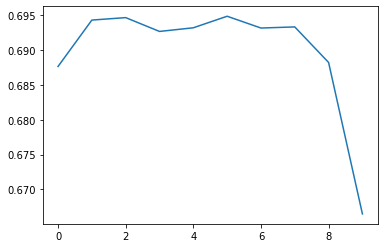

In [10]:
import matplotlib.pyplot as plt

plt.plot(loss_arr)
plt.show()